In [1]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dag_prf_utils.plot_functions import *
%matplotlib inline

import tensorflow as tf
tf.config.list_physical_devices('GPU')

Could not find path for freeview, is freesurfer accessible from here?
Could not find FS_LICENSE
Uncomment line below and specify path to FS_LICENSE
Error importing pycortex... Not a problem unless you want to use pycortex stuff
SUBJECTS_DIR not found in os.environ
Adding empty string...


[]

In [2]:
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]

x, y = np.meshgrid(np.linspace(-.75, .75, 3), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 3))

In [3]:
parameters = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':1,
               'baseline':0.0}).astype(np.float32)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

In [4]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel

In [5]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))

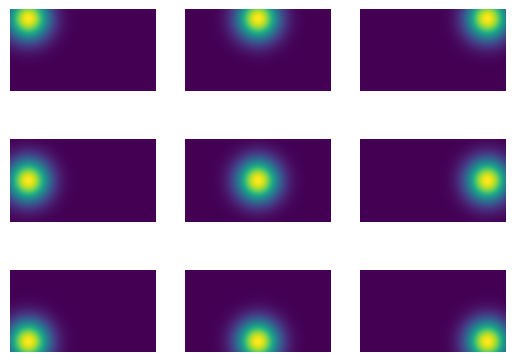

In [6]:
for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(model.get_rf()[i].reshape((240, 135)).T)
    plt.axis("off")

## Predictions (no noise)

<Axes: xlabel='frame'>

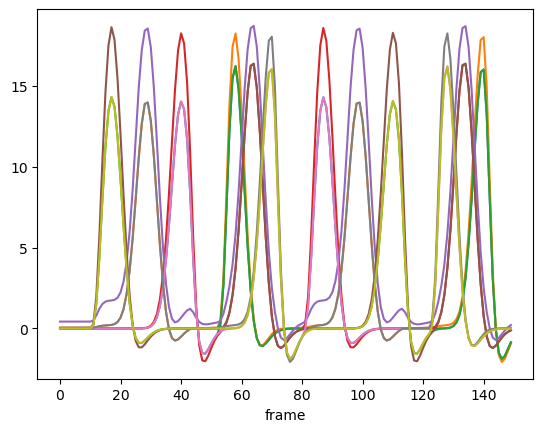

In [7]:
pred = model.predict()
pred.plot(legend=False)

## Noisy predictions

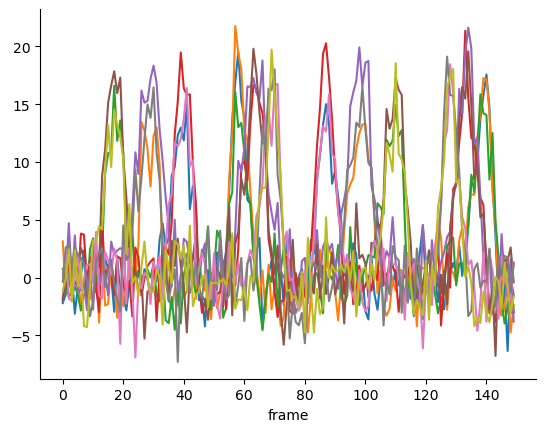

In [45]:
data = model.simulate(noise=2)
data.plot(legend=False)
sns.despine()

# Estimate parameters

In [46]:
from braincoder.optimize import ParameterFitter
from braincoder.bprf_mcmc import BPRF

In [47]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
cfitter = ParameterFitter(model, data, paradigm)


grid_pars = cfitter.fit_grid(x=np.linspace(-1, 1, 20), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 10),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars)

Working with chunk size of 493827
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 9


Current R2: 0.87277/Best R2: 0.87277:  18%|█▊        | 180/1000 [00:02<00:09, 83.51it/s] 


In [48]:
cfitter.get_rsq(refined_pars)

source
0    0.896256
1    0.860924
2    0.835760
3    0.909260
4    0.895081
5    0.886253
6    0.858464
7    0.861894
8    0.851047
Name: r2, dtype: float32

parameter         x         y        sd  baseline  amplitude
0         -0.744046 -0.476158  0.248393 -0.481711    1.11605


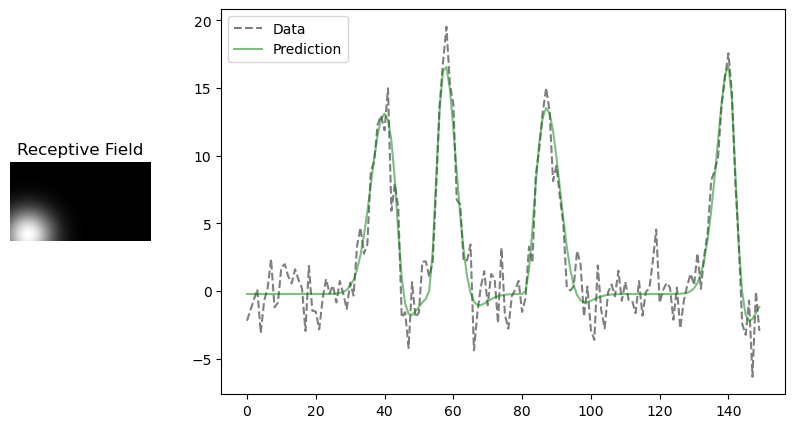

In [51]:
idx = 0
from braincoder.utils.visualize import quick_plot
quick_plot(
    model=model, 
    parameters=refined_pars.iloc[idx,:],
    data=data.iloc[:,idx]
)

# MCMC Gaussian

In [69]:
bounds = {
    'x' : [-1, 1],
    'y' : [-1, 1],
    'sd' : [0, 10],
    'baseline' : [-1,1],
    'amplitude' : [0, 10], 
}

n_vx = parameters.shape[0]
init_pars = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.ones(n_vx),
    'amplitude' : np.ones(n_vx),
    'baseline' : np.zeros(n_vx),
})


bfitter = BPRF(model=model, data=data, )
# bfitter.add_prior(
#     pid='x', prior_type='normal', loc=0, scale=5
# )
# bfitter.add_prior(
#     pid='y', prior_type='normal', loc=0, scale=5
# )
# bfitter.add_prior(
#     pid='sd', prior_type='uniform', vmin=0, vmax=10
# )
# bfitter.add_prior(
#     pid='amplitude', prior_type='uniform', vmin=0, vmax=100
# )

# bfitter.add_prior(
#     pid='baseline', prior_type='uniform', vmin=-1, vmax=1
# )
bfitter.add_bijector(
    'x', 'sigmoid', low=-1, high=1
)
bfitter.add_bijector(
    'y', 'sigmoid', low=-1, high=1
)
bfitter.prep_for_fitting()


In [70]:
idx = 0
num_results = 50
tf.random.set_seed(1)
bfitter.fit(
    idx=idx,
    init_pars=init_pars,
    num_results=num_results,
)
tf.random.set_seed(1)
# bfitterL.fit(
#     idx=idx,
#     init_pars=init_pars,
#     num_results=num_results,         
# )

idx=[0]; initial_ll=[-3091.0234]


/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_78889/1982355676.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


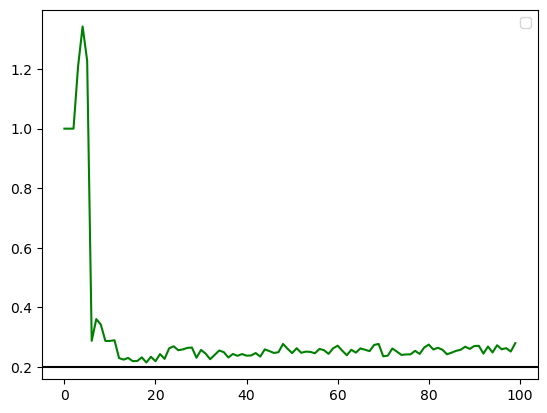

In [72]:
# Lets compare...
p = 'sd'
# plt.plot(
#     bfitterL.mcmc_sampler[idx][p],
#     color='r', label='latent versions')
plt.plot(
    bfitter.mcmc_sampler[idx][p],
    color='g',) #label='no bijector versions')
plt.axhline(
    parameters[p][idx], color='k'
)
plt.legend()

In [63]:
bfitter.mcmc_sampler[idx][p]

0     1.000000
1     1.000000
2     1.000000
3     0.698413
4     0.712064
        ...   
95    0.432382
96    0.459483
97    0.470221
98    0.462361
99    0.456647
Name: sd, Length: 100, dtype: float32

In [ ]:
bfitterL.mcmc_sampler[idx]

In [43]:
rsq = bfitter.get_rsq_for_idx(
    idx=idx, parameters=bfitter.mcmc_sampler[idx],
)

rsq_cols = dag_get_col_vals(
    rsq, cmap='RdBu_r', vmin=-1, vmax=1,
    )

/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_78889/586484379.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


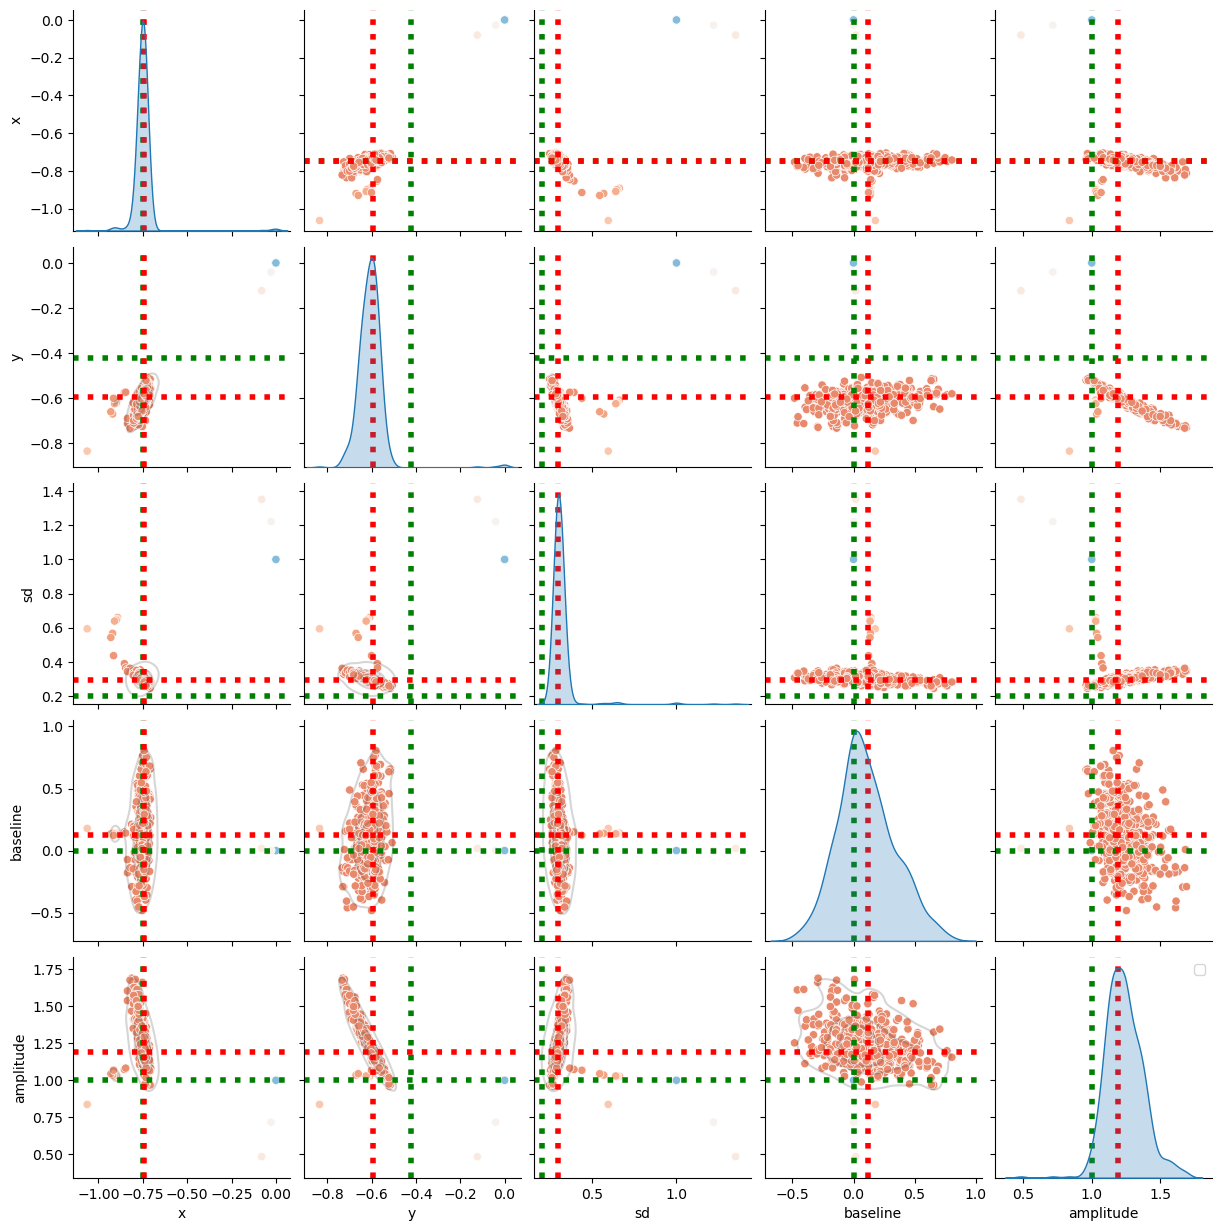

In [44]:
idx = 0
burn_in = 0
sns_plot = sns.pairplot(
    bfitter.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.
add_lines_to_pairplot(
    sns_plot.axes, parameters.iloc[idx,:].to_dict(), color='g', linestyle=':', lw=4, label='Truth'
)
# add_lines_to_pairplot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
add_lines_to_pairplot(
    sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
)
plt.legend()
plt.show()

In [ ]:
p = 'amplitude'
plt.plot(bfitter.mcmc_sampler[idx][p])
plt.axhline(parameters.iloc[idx][p], c='r')

# Mexican hat model

In [21]:
from braincoder.models import DifferenceOfGaussiansPRF2DWithHRF

In [ ]:
parameters_dog = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.3,
               'baseline':0.0,
               'srf_amplitude':.5, 
               'srf_size':2}).astype(np.float32)
model_dog = DifferenceOfGaussiansPRF2DWithHRF(grid_coordinates, paradigm, parameters=parameters_dog,
                                             hrf_model=SPMHRFModel(tr=1.8))
pred_dog = model_dog.predict()
pred_dog.plot()

In [ ]:
data_dog = model_dog.simulate(noise=.1)
data_dog.plot(legend=False)
sns.despine()

In [24]:
fitter_dog = ParameterFitter(model_dog, data_dog, paradigm)

In [25]:
init_pars_dog = refined_pars.copy()
init_pars_dog['srf_amplitude'] = 0.1
init_pars_dog['srf_size'] = 2.

In [ ]:
est_pars_dog = fitter_dog.fit(
    init_pars=init_pars_dog, learning_rate=0.001,
    max_n_iterations=10000,
    )

In [ ]:
idx = 0
est_pred = model_dog.predict(parameters=est_pars_dog)
est_pred[idx].plot()
data_dog[idx].plot()
print(est_pars_dog.iloc[idx,:])
print(parameters_dog.iloc[idx,:])


# MCMC - DOG

In [60]:
bounds_dog = {
    'x' : [-5, 5],
    'y' : [-5, 5],
    'sd' : [0, 10],
    'baseline' : [-2,2],
    'amplitude' : [0,100], 
    'srf_amplitude': [0, 10],
    'srf_size' : [1, 10],

}

n_vx = parameters_dog.shape[0]
# init_pars_dog = pd.DataFrame({    
#     'x' : np.zeros(n_vx),
#     'y' : np.zeros(n_vx),
#     'sd' : np.zeros(n_vx),
#     'baseline' : np.zeros(n_vx),
#     'amplitude' : np.zeros(n_vx),
#     'srf_amplitude' : np.zeros(n_vx),
#     'srf_size' : np.zeros(n_vx),

# })
bfitter_dog = BPRF(model=model_dog, data=data_dog, )
bfitter_dog.add_priors_from_bounds(bounds_dog, ) #prior_type='latent_uniform')
bfitter_dog.prep_for_fitting()

In [ ]:
bfitter_dog.fit(
    idx=[1,], #2,3], 
    init_pars=init_pars_dog,
    num_results=200,         
)

In [ ]:
idx = 1
burn_in = 0

rsq = bfitter_dog.get_rsq_for_idx(
    idx=idx, parameters=bfitter_dog.mcmc_sampler[idx],
)

rsq_cols = dag_get_col_vals(
    rsq, cmap='RdBu_r', vmin=-1, vmax=1,
    )

sns_plot = sns.pairplot(
    bfitter_dog.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.
add_lines_to_pairplot(
    sns_plot.axes, parameters_dog.iloc[idx,:].to_dict(), color='g', linestyle=':'
)
# add_lines_to_pairplot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# add_lines_to_pairplot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.show()

In [ ]:
plt.plot(
    bfitter_dog.mcmc_sampler[idx].x
)

In [ ]:
bfitter_dog.mcmc_sampler[idx].shape

In [ ]:
bfitter_dog.mcmc_sampler[0].x